# Modèle de regression

# Chargement et mise en forme des données

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from math import log,sqrt,exp

import random
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, LassoLarsCV
from itertools import cycle

In [6]:
PATH = '../requetes/'
data = pd.read_csv(PATH+'requetes_total.csv')
data.head()

,avatar_id,city,date,language,mobile,hotel_id,price,stock,group,brand,parking,pool,children_policy
0,29822,madrid,2,bulgarian,0,127,69,0,Independant,Independant,1,0,0
1,29822,madrid,2,bulgarian,0,941,67,0,Independant,Independant,1,0,0
2,29822,madrid,2,bulgarian,0,186,129,0,Yin Yang,Ardisson,1,0,0
3,29822,madrid,2,bulgarian,0,633,148,2,Morriott International,CourtYord,0,0,0
4,29822,madrid,2,bulgarian,0,241,126,0,Boss Western,J.Halliday Inn,1,0,0


In [7]:
# transformation des données en fonction de celles qu'on a identifié dans le notebook d'analyse des données de requetes
data["price_mod"]=data["price"].map(lambda x: log(x))
data["stock_mod"]=data["stock"].map(lambda x: sqrt(x))
data_mod = data.drop(["price","stock"],axis=1)

Pour la mise en forme des données, je décide d'ajouter une colonne order_request, comme dans le set de test. On verra bien ce que ça donne. 

Les lignes qui sont issues du résultat de la même requête se caractérisent par un ID d'utilisateur constant, une ville et une date constantes. 

In [8]:
order = np.zeros(len(data_mod.index),dtype=int)

# référence pour le début = la première ligne du dataframe
ref_line = 0
order[0] = 1

for line in range(0,len(data_mod.index)):
    request_line = data_mod.loc[line,['avatar_id','city','date']].to_numpy()
    request_ref_line = data_mod.loc[ref_line,['avatar_id','city','date']].to_numpy() 
    if (request_line == request_ref_line).all() :
        order[line] = order[ref_line]
    else : 
        order[line] = order[ref_line]+1
        ref_line = line

In [9]:
data_mod['order_requests'] = order
data_mod.head()

,avatar_id,city,date,language,mobile,hotel_id,group,brand,parking,pool,children_policy,price_mod,stock_mod,order_requests
0,29822,madrid,2,bulgarian,0,127,Independant,Independant,1,0,0,4.234107,0.000000,1
1,29822,madrid,2,bulgarian,0,941,Independant,Independant,1,0,0,4.204693,0.000000,1
2,29822,madrid,2,bulgarian,0,186,Yin Yang,Ardisson,1,0,0,4.859812,0.000000,1
3,29822,madrid,2,bulgarian,0,633,Morriott International,CourtYord,0,0,0,4.997212,1.414214,1
4,29822,madrid,2,bulgarian,0,241,Boss Western,J.Halliday Inn,1,0,0,4.836282,0.000000,1


On change les types des variables.

In [10]:
# définition des variables quntitatives et qualitatives : 
var_quant = ["date","stock_mod"]
var_quali = ["city","language", "mobile","group","brand","parking","pool","children_policy"]

for var in var_quali :
    data_mod[var]=pd.Categorical(data_mod[var],ordered=False)

data_mod.dtypes

avatar_id             int64
city               category
date                  int64
language           category
mobile             category
hotel_id              int64
group              category
brand              category
parking            category
pool               category
children_policy    category
price_mod           float64
stock_mod           float64
order_requests        int64
dtype: object

In [11]:
# Renormalisation des variables quantitatives : 
scalerX = StandardScaler()  
scalerX.fit(data_mod[var_quant])  
X_quant = pd.DataFrame(scalerX.transform(data_mod[var_quant]),columns=var_quant)

# Séparation de l'output :
Y = data_mod["price_mod"].to_numpy()

RQ : quand on utilise le set de test, ne pas oublier d'effectuer les mêmes modifications sur le tableau de données (log,sqrt,renormalisation)

In [12]:
# transformation des variables qualitatives en dummy variables
X_dum = pd.get_dummies(data_mod[var_quali])
X = pd.concat([data_mod[['order_requests','avatar_id','hotel_id']],X_quant,X_dum],axis=1)

Selon le modèle il faut transformer les variables qualitatives en dummy variables => s'en souvenir !

# Fonctions utiles

In [13]:
def plot_pred_obs(Y_true,Y_pred): 
    plt.figure(figsize=(5,5))
    plt.plot(Y_true,Y_pred,"o",markersize = 0.4)
    plt.xlabel("prix prédit")
    plt.ylabel("prix observé")
    plt.show()

def scatterplot_residuals(Y_true,Y_pred):
    plt.figure(figsize=(5,5))
    plt.plot(Y_pred,Y_true-Y_pred,"o",markersize = 0.4)
    plt.xlabel(u"valeurs prédites")
    plt.ylabel(u"Résidus")
    plt.title("Residus pénalité L1 Lasso") 
    plt.hlines(0,0,3)
    plt.show()
    
def histogram_residuals(Y_true,Y_pred):
    plt.figure(figsize=(10,5))
    plt.hist(Y_true-Y_pred,bins=20)
    plt.title('histogramme des résidus')
    plt.xlabel('valeur des résidus')
    plt.ylabel('nombre de prédictions')
    plt.show()
    

In [14]:
def download_pred_Xtest(Y_pred,name_model) :
    Y_pred['index'] = Y_pred.index
    Y_pred = Y_pred[['index','price']]
    Y_pred.to_csv('../predictions/'+name_model+'.csv',index=False)

# Préparation des données de test 

In [15]:
# chargement des données de test : 
data_test = pd.read_csv('../Test_set_analysis/test_set_complet.csv')
data_test.dtypes

order_requests      int64
city               object
date                int64
language           object
mobile              int64
avatar_id           int64
hotel_id            int64
stock               int64
group              object
brand              object
parking             int64
pool                int64
children_policy     int64
dtype: object

In [16]:
# apply the same transformations on the test set : 
# qualitative variables to categorical 
for var in var_quali :
    data_test[var]=pd.Categorical(data_test[var],ordered=False)
    
# recentrer et renormaliser les variables : 
data_test["stock_mod"]=data_test["stock"].map(lambda x: sqrt(x))
data_test_mod = data_test.drop(["stock"],axis=1)
scaler_test = StandardScaler()  
scaler_test.fit(data_test_mod[var_quant])
X_test_quant = pd.DataFrame(scaler_test.transform(data_test_mod[var_quant]),columns=var_quant)

# transformation des variables qualitatives en dummy variables
X_test_dum = pd.get_dummies(data_test_mod[var_quali])
X_test = pd.concat([data_test_mod[['order_requests']],X_test_quant,X_test_dum],axis=1)

# Séparation des données en échantillon d'entrainement et validation

In [17]:
# 20% des avatar_ID seront dans le test set et 80% dans le train set
random.seed(0)
alpha = 0.8
ind_user = np.unique(data_mod['avatar_id'])
n = len(ind_user)
random.shuffle(ind_user)
ind_train = ind_user[:int(alpha*n)]
ind_vali = ind_user[int(alpha*n):]

# sélection des lignes correspondantes dans le dataframe 
X_train = X.loc[X['avatar_id'].isin(ind_train)]
X_vali = X.loc[X['avatar_id'].isin(ind_vali)]

In [18]:
# séparation de la colonne des outputs en training et validation : 
indX_train = X.index[X['avatar_id'].isin(ind_train)]
Y_train = Y[indX_train]
indX_vali = X.index[X['avatar_id'].isin(ind_vali)]
Y_vali = Y[indX_vali]

In [19]:
# suppression des ID maintenant qu'on en a plus besoin
X_train.drop(['avatar_id','hotel_id'],axis=1,inplace=True)
X_vali.drop(['avatar_id','hotel_id'],axis=1,inplace=True)

/tmp/ipykernel_3750/883078845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['avatar_id','hotel_id'],axis=1,inplace=True)
/tmp/ipykernel_3750/883078845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_vali.drop(['avatar_id','hotel_id'],axis=1,inplace=True)


# Construction du modèle et analyse des résultats

In [20]:
regLasso = linear_model.Lasso(alpha=0)
regLasso.fit(X_train,Y_train)
prev=regLasso.predict(X_vali)
print("RMSE=",np.sqrt(mean_squared_error(Y_vali,prev))) # sur les résultats normalisés

/tmp/ipykernel_3750/2613064210.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regLasso.fit(X_train,Y_train)
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


RMSE= 0.1398976283915322


/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+03, tolerance: 3.842e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [21]:
# MSE sur les données dénormalisées et détransformées : 
prev_detransfo = np.exp(prev)
Y_vali_detransfo = np.exp(Y_vali)
print("RMSE sur les résultats dénormalisés =",np.sqrt(mean_squared_error(Y_vali_detransfo,prev_detransfo)))
print("MAE sur les résultats dénormalisés =",mean_absolute_error(Y_vali_detransfo,prev_detransfo))

RMSE sur les résultats dénormalisés = 22.392859271432076
MAE sur les résultats dénormalisés = 14.561951286967815


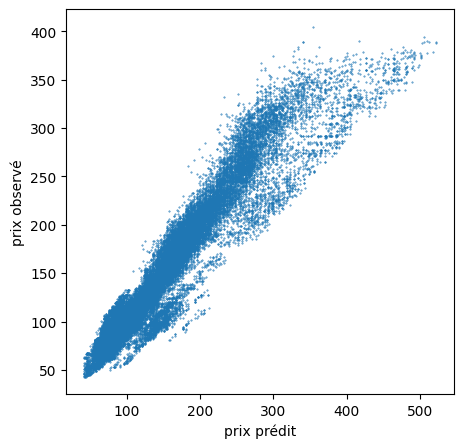

In [22]:
plot_pred_obs(Y_vali_detransfo,prev_detransfo)

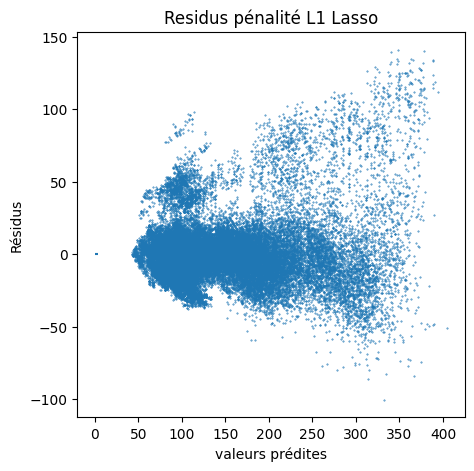

In [23]:
scatterplot_residuals(Y_vali_detransfo,prev_detransfo)

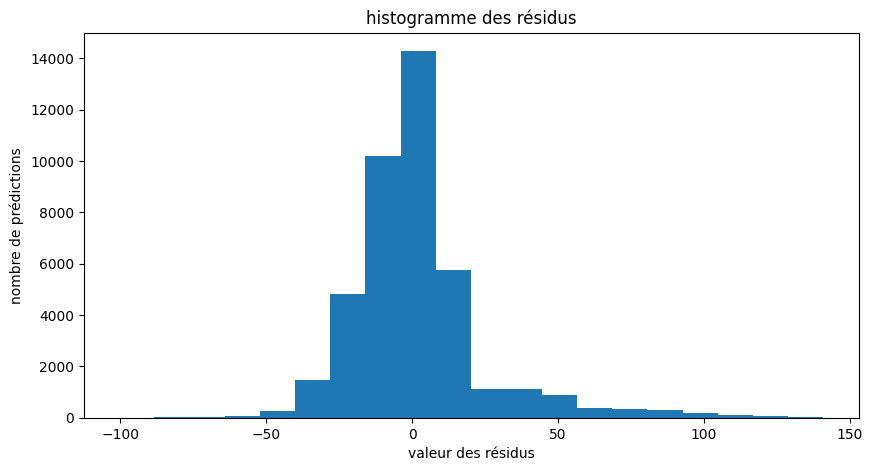

In [24]:
histogram_residuals(Y_vali_detransfo,prev_detransfo)

In [25]:
# On ré-entraine l'algo sur tout le jeu de données et on prédit le set de test : 
regLasso_complet = linear_model.Lasso(alpha=0)
regLasso_complet.fit(X.drop(['avatar_id','hotel_id'],axis=1),Y)
prev = regLasso_complet.predict(X_test)
prev = pd.DataFrame(np.exp(prev),columns=['price'])
download_pred_Xtest(prev,'prediction_regLineaire')

/tmp/ipykernel_3750/3211055345.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regLasso_complet.fit(X.drop(['avatar_id','hotel_id'],axis=1),Y)
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e+03, tolerance: 4.737e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coord

# Optimisation du terme de pénalisation Lasso par grid search
Le paramètre de pénalisation lasso est optimisé par validation croisée.

In [26]:
# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":[0.0001,0.001,0.01]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(X_train, Y_train)
# paramètre optimal
regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

Meilleur R2 = 0.913014, Meilleur paramètre = {'alpha': 0.0001}


La meilleure valeur du paramètre alpha est la plus faible. En fait, si on teste alpha = 0 est même mieux, mais pour un soucis d'overfit on veut prendre alpha > 0. Quand alpha = 0, on se ramène à de la regression linéaire.

On refait la prédiction de l'échantillon de validation avec la meilleure valeur du paramètre alpha

In [27]:
prev=regLassOpt.predict(X_vali)
# enlver la transformation : 
prev_detransfo = np.exp(prev)
Y_vali_detransfo = np.exp(Y_vali)
print("résultats pour le modèle linéaire LASSO")
print("-----------------------------------------")
print("RMSE=",np.sqrt(mean_squared_error(prev_detransfo,Y_vali_detransfo)))
print("R2=",r2_score(Y_vali_detransfo,Y_vali_detransfo))

résultats pour le modèle linéaire LASSO
-----------------------------------------
RMSE= 22.47256435229359
R2= 1.0


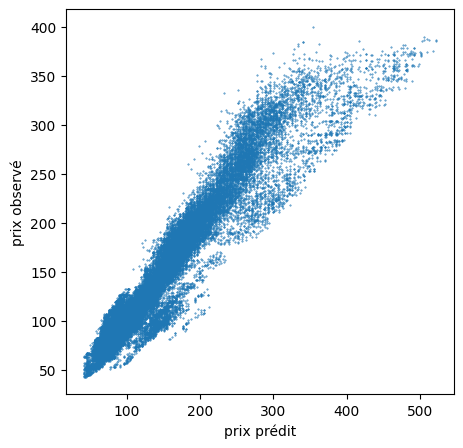

In [28]:
plot_pred_obs(Y_vali_detransfo,prev_detransfo)

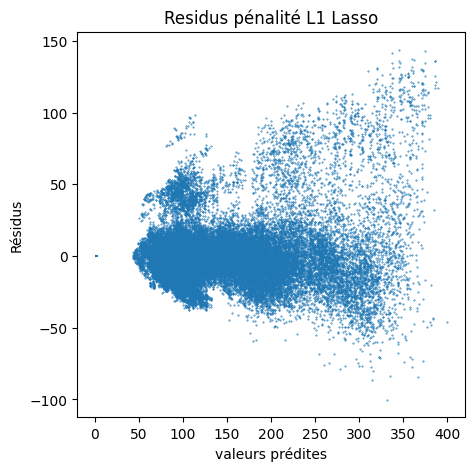

In [29]:
scatterplot_residuals(Y_vali_detransfo,prev_detransfo)

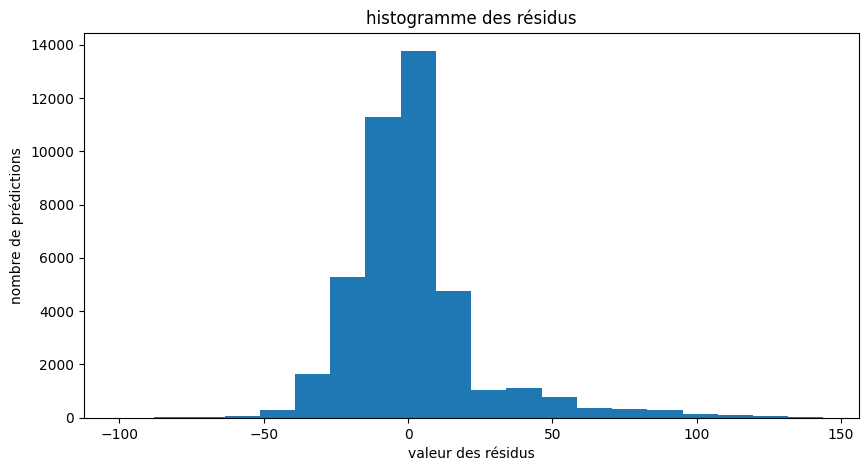

In [30]:
histogram_residuals(Y_vali_detransfo,prev_detransfo)

Analyse des paramètres du modèle :

Lasso conserve 58 variables et en supprime 12


Text(0.5, 1.0, 'Coefficients du modèle lasso')

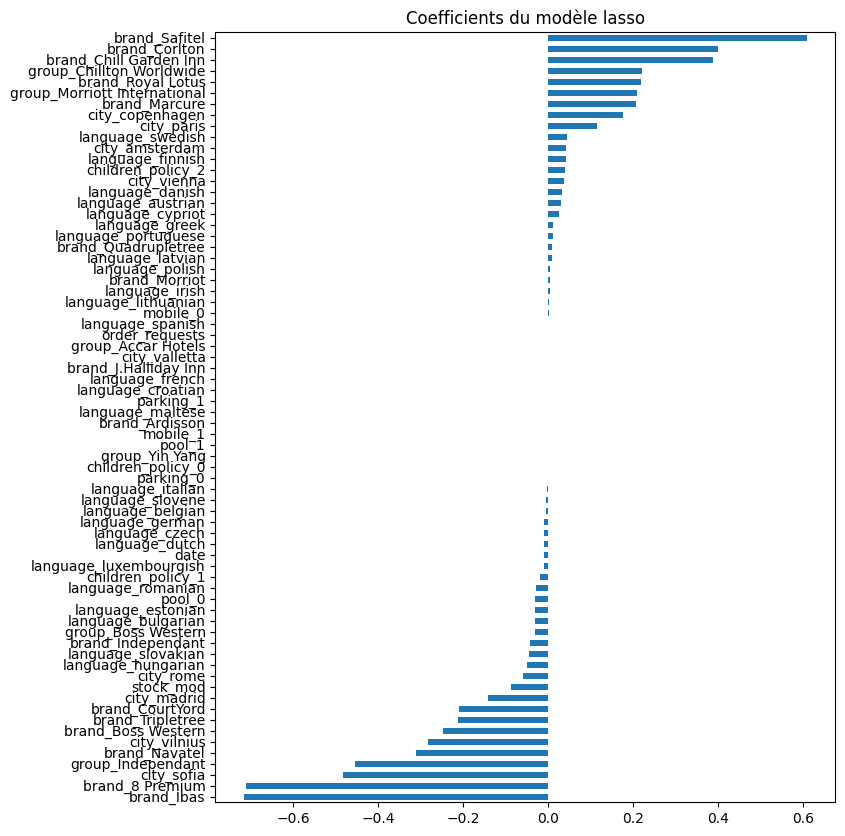

In [31]:
# Coefficients
regLasso=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])
model_lasso=regLasso.fit(X_train,Y_train)
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

# Optimisation du terme de pénalisation Lasso par LassoCV

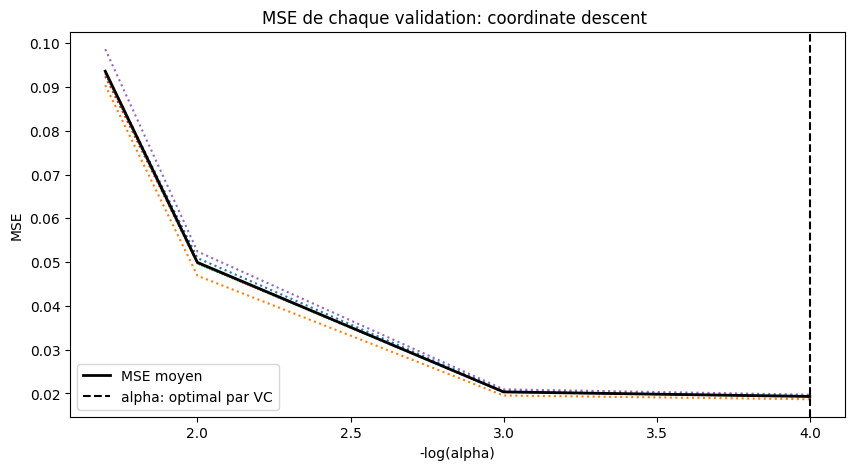

alpha optimal nouvel algo 0.0001
alpha optimal trouvé précédemment {'alpha': 0.0001}


In [32]:
#from sklearn.linear_model import LassoCV, LassoLarsCV
model = LassoCV(cv=5, alphas=[0.0001,0.001,0.01,0.02],n_jobs=-1,random_state=13).fit(X_train,Y_train)
m_log_alphas = -np.log10(model.alphas_)

plt.figure(figsize=(10,5))
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='MSE moyen', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: optimal par VC')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('MSE')
plt.title('MSE de chaque validation: coordinate descent ')
plt.show()

print("alpha optimal nouvel algo", model.alpha_)
print("alpha optimal trouvé précédemment",regLassOpt.best_params_)

On ré-entraine le modèle sur tout le jeu de données et on prédit l'échantillon de test

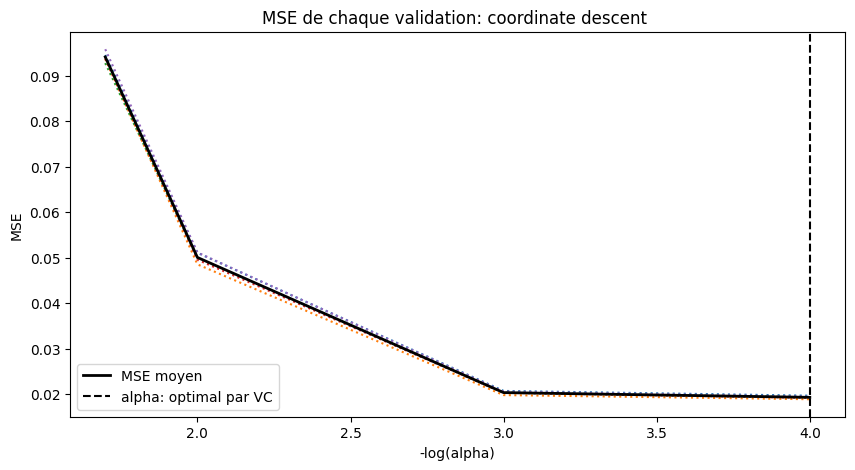

alpha optimal nouvel algo 0.0001
alpha optimal trouvé précédemment {'alpha': 0.0001}


In [33]:
#from sklearn.linear_model import LassoCV, LassoLarsCV
model = LassoCV(cv=5, alphas=[0.0001,0.001,0.01,0.02],n_jobs=-1,random_state=13).fit(X.drop(['avatar_id','hotel_id'],axis=1),Y)
m_log_alphas = -np.log10(model.alphas_)

plt.figure(figsize=(10,5))
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='MSE moyen', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: optimal par VC')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('MSE')
plt.title('MSE de chaque validation: coordinate descent ')
plt.show()

print("alpha optimal nouvel algo", model.alpha_)
print("alpha optimal trouvé précédemment",regLassOpt.best_params_)

In [34]:
regLasso_penalise = linear_model.Lasso(alpha=model.alpha_)
regLasso_penalise.fit(X.drop(['avatar_id','hotel_id'],axis=1),Y)
prev = regLasso_penalise.predict(X_test)
prev = pd.DataFrame(np.exp(prev),columns=['price'])
download_pred_Xtest(prev,'prediction_regLasso')